In [1]:
from datasets import load_dataset
import Preprocessor as p

# Load the copenlu/answerable_tydiqa dataset
dataset = load_dataset("copenlu/answerable_tydiqa")


train_df = dataset['train'].to_pandas()
train_df = train_df[train_df['language'].isin(['indonesian', 'arabic', 'bengali'])]
train_df = p.DataFramePreprocessor(train_df, columns_to_tokenize=['document_plaintext', 'question_text'], remove_stopwords=False).df
train_arabic = train_df[train_df['language'] == 'arabic']
train_indonesian = train_df[train_df['language'] == 'indonesian']
train_bengali = train_df[train_df['language'] == 'bengali']

val_df = dataset['validation'].to_pandas()
val_df = val_df[val_df['language'].isin(['indonesian', 'arabic', 'bengali'])]
val_df = p.DataFramePreprocessor(val_df, columns_to_tokenize=['document_plaintext', 'question_text'], remove_stopwords = False).df
val_arabic = val_df[val_df['language'] == 'arabic']
val_indonesian = val_df[val_df['language'] == 'indonesian']
val_bengali = val_df[val_df['language'] == 'bengali']


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

def compute_token_tfidf(train_df, val_df, doc_token_col_name='document_plaintext_tokens', ques_token_col_name='question_text_tokens', _max_features=50):

    # Join the tokens into single strings for documents and questions
    train_docs = train_df[doc_token_col_name].apply(' '.join)
    train_ques = train_df[ques_token_col_name].apply(' '.join)
    val_docs = val_df[doc_token_col_name].apply(' '.join)
    val_ques = val_df[ques_token_col_name].apply(' '.join)

    # Combine training documents and questions
    combined_train = train_docs + ' ' + train_ques
    combined_val = val_docs + ' ' + val_ques

    # Initialize vectorizer and fit on combined training data
    vectorizer = TfidfVectorizer(max_features=_max_features)
    vectorizer.fit(combined_train)

    # Transform the documents and questions
    train_docs_tfidf = vectorizer.transform(train_docs).toarray()
    train_ques_tfidf = vectorizer.transform(train_ques).toarray()
    val_docs_tfidf = vectorizer.transform(val_docs).toarray()
    val_ques_tfidf = vectorizer.transform(val_ques).toarray()

    # Store the results back in the DataFrame
    train_df['document_token_tfidf'] = list(train_docs_tfidf)
    train_df['question_token_tfidf'] = list(train_ques_tfidf)
    val_df['document_token_tfidf'] = list(val_docs_tfidf)
    val_df['question_token_tfidf'] = list(val_ques_tfidf)

    return train_df, val_df

df_tfidf_train, df_tfidf_val = compute_token_tfidf(train_arabic, val_arabic)


/var/folders/zr/c8f6vstn63316p5z6pj3jlp00000gn/T/ipykernel_2135/2829081276.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['document_token_tfidf'] = list(train_docs_tfidf)
/var/folders/zr/c8f6vstn63316p5z6pj3jlp00000gn/T/ipykernel_2135/2829081276.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['question_token_tfidf'] = list(train_ques_tfidf)
/var/folders/zr/c8f6vstn63316p5z6pj3jlp00000gn/T/ipykernel_2135/2829081276.py:29: SettingWithCopyWarning: 
A value is trying to be set on a 

In [16]:
import numpy as np 
def create_y_label(df_tfidf):
    df_tfidf['is_answerable'] = df_tfidf['annotations'].apply(lambda x: x['answer_start'][0])
    df_tfidf['is_answerable'] = np.where(df_tfidf['is_answerable'] > 0, 1, 0)

create_y_label(df_tfidf_train)
create_y_label(df_tfidf_val)


/var/folders/zr/c8f6vstn63316p5z6pj3jlp00000gn/T/ipykernel_2135/807390188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tfidf['is_answerable'] = df_tfidf['annotations'].apply(lambda x: x['answer_start'][0])
/var/folders/zr/c8f6vstn63316p5z6pj3jlp00000gn/T/ipykernel_2135/807390188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tfidf['is_answerable'] = np.where(df_tfidf['is_answerable'] > 0, 1, 0)


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Prepare training data
X_train = [np.array(doc + ques) for doc, ques in zip(df_tfidf_train['document_token_tfidf'].tolist(), df_tfidf_train['question_token_tfidf'].tolist())]
X_train = np.vstack(X_train)
y_train = df_tfidf_train['is_answerable'].tolist()

# Prepare validation data
X_val = [np.array(doc + ques) for doc, ques in zip(df_tfidf_val['document_token_tfidf'].tolist(), df_tfidf_val['question_token_tfidf'].tolist())]
X_val = np.vstack(X_val)
y_val = df_tfidf_val['is_answerable'].tolist()

# Training the Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predicting on the validation set
y_pred = clf.predict(X_val)

# Evaluating the classifier's performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.6556256572029443

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.72      0.68       968
           1       0.67      0.59      0.63       934

    accuracy                           0.66      1902
   macro avg       0.66      0.65      0.65      1902
weighted avg       0.66      0.66      0.65      1902



In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the model
clf = MultinomialNB()

# Define the hyperparameters and their possible values
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'fit_prior': [True, False],
}

# Set up the grid search
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_val)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)


Best parameters found:  {'alpha': 0.001, 'fit_prior': False}
Accuracy: 0.650893796004206

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66       968
           1       0.65      0.63      0.64       934

    accuracy                           0.65      1902
   macro avg       0.65      0.65      0.65      1902
weighted avg       0.65      0.65      0.65      1902



Training Accuracy: 0.699154486465229
Training Log Loss: 10.843571413518236

Confusion Matrix:
 [[1238  489]
 [ 617  973]]


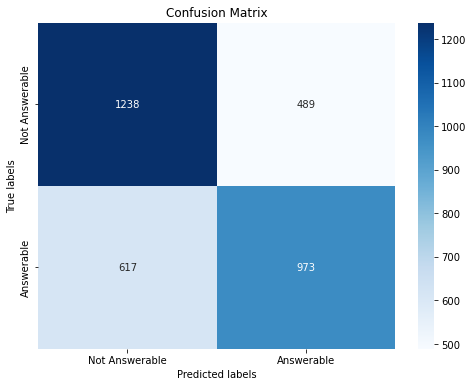

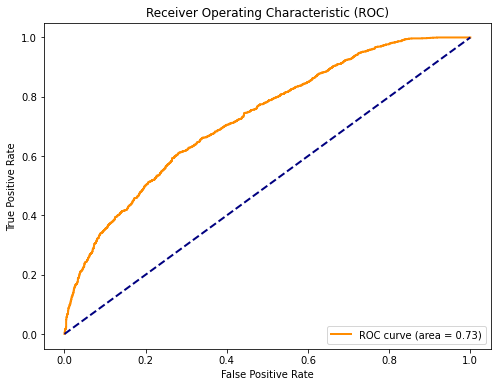

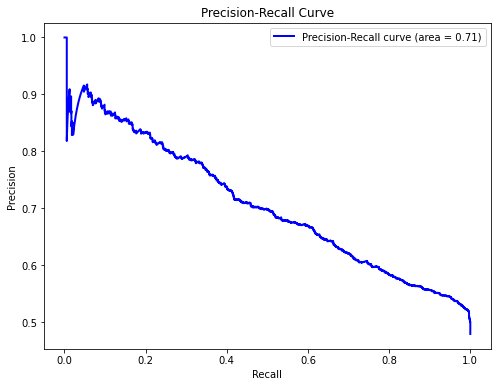


Validation Log Loss: 0.5961838909563054


/Users/jensthyregod/mambaforge/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns  # For a nicer confusion matrix visualization

# Training metrics
y_train_pred = clf.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Training Log Loss:", log_loss(y_train, y_train_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", cm)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not Answerable', 'Answerable'], 
            yticklabels=['Not Answerable', 'Answerable'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, clf.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, clf.predict_proba(X_val)[:,1])
average_precision = average_precision_score(y_val, clf.predict_proba(X_val)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

# Log Loss on Validation Data
print("\nValidation Log Loss:", log_loss(y_val, clf.predict_proba(X_val)))
